### Business Understanding

The purpose of this excercise is to take the various parameters in the dataset and determine what materially impacts prices. After creating a model, we need to determine what vehicle types need to be kept in stock to maximize return on investment, minimize working capital needs and maximize inventory turnover (increase velocity of car sales). In this analysis, we have optmized for maximizing return on investment by advising stocking vehicles that have the higest sales price.   

In [33]:
#Importing libraries that are needed to carry out the analysis
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures



import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import datetime 
import warnings
warnings.filterwarnings('ignore') #Ignoring warnings

In [34]:
#Reading in the vehicles data into a dataframe
data_df = pd.read_csv('vehicles.csv')

### Data Understanding

Making sure that we clean the data and remove null values

In [35]:
#Determining what columns have null values and what % of the total data is null. This is essential for cleaning the data
A = pd.DataFrame(data_df.isnull().sum())
A.rename(columns = {0:'Null values'}, inplace = True)
A['Percentage of Null Values']= (A['Null values']/426880)*100
A

Null values  Percentage of Null Values
id                      0                   0.000000
region                  0                   0.000000
price                   0                   0.000000
year                 1205                   0.282281
manufacturer        17646                   4.133714
model                5277                   1.236179
condition          174104                  40.785232
cylinders          177678                  41.622470
fuel                 3013                   0.705819
odometer             4400                   1.030735
title_status         8242                   1.930753
transmission         2556                   0.598763
VIN                161042                  37.725356
drive              130567                  30.586347
size               306361                  71.767476
type                92858                  21.752717
paint_color        130203                  30.501078
state                   0                   0.000000

### Data Preparation

Cleaning the data and removing null values, dopping columns that are not needed

In [36]:
#Dropping null values. Also dropping id, VIN, region and state columns since they do not add any value in determining price.
B = data_df.dropna()
B.drop(['id','VIN', 'region','state'], axis=1, inplace=True)

# Converting the year of manufacturing of the car to age so that we have a numeric column to work with

B['age'] = datetime.date.today().year - B['year']
B.drop(['year'], axis=1, inplace=True)

In [37]:
# Dropping rows where price is zero as it does not help in determining price. These seem to be outlier scenarios.
index_names = B[B['price']==0].index
B.drop(index_names, inplace = True)

In [38]:
# Determining what the correlation is of the numeric values with the price to determine if there are additional columns with weak correlations that can be dropped
B_corr = B.corr().drop(['odometer', 'age'], axis=1)
B_corr = B_corr.drop(['price'], axis=0)
B_corr

price
odometer -0.233358
age      -0.315430

We see that the odometer reading and age of the car both have high correlations with the price and hence both parameters need to be retained in the analysis


In [39]:
# Setting the features of the dataset. All columns of the data set have been retained as features except the dropped columns mentioned above
features=['age','condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
          'drive', 'size','type', 'paint_color']
X = B[features]
y= np.log(B['price']) # The log of the price has been considered to ensure we are not predicting negative prices. 

In [40]:
# Splitting the data into training and test data with a split of 70% of training data and 30% testing data
X_train, X_test,y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state = 22)

### Modeling

At this point I test 3 models to determine which model has the lowest Mean squared error and use that to make the prediction. The 3 models used are as follows:
1) Linear Regression
2) Ridge Regression
3) LASSO 
The non numeric parameters have been one hot encoded to ensure that they can be used in the model

In [41]:
#Building a Linear Regression model on the dataset to determine the performance of a simple linear regression model.
#The parameters that are not numeric have been one hot encoded.
train_mse_linreg=[]
test_mse_linreg=[]
scores=[]

for i in range (1,6):
#Creating a pipeline with PolynomialFeatures degree i. The reason for passing the parameter handle_unknown to ignore 
#is because in the test data there are 2 datapoints in title that are parts only that are not recognized. Since the datapoints are not large enough this decision has been made. 
    col_transformer_linreg = make_column_transformer((PolynomialFeatures(degree = i, include_bias=False), ['odometer', 'age']),
                                        (OneHotEncoder(drop = 'if_binary', handle_unknown='ignore'), ['cylinders','condition','fuel', 'title_status', 'transmission',
          'drive', 'size','type', 'paint_color']))
    pipe_linreg = Pipeline ([
    ("column_transformer", col_transformer_linreg),
    ("model_linreg", LinearRegression())
    ])
#Fitting the data with the polynomial features    
    pipe_linreg.fit(X_train[['age','condition','cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
          'drive', 'size','type', 'paint_color']],y_train)
#Making predictions using the model  
    Pred_train_linreg = pipe_linreg.predict(X_train)
    Pred_test_linreg = pipe_linreg.predict(X_test)
#Determining mean squared errors
    mse_train_linreg = mean_squared_error(y_train,Pred_train_linreg) 
    mse_test_linreg = mean_squared_error(y_test,Pred_test_linreg)
#appending these to the training list
    train_mse_linreg.append(mse_train_linreg)
    test_mse_linreg.append(mse_test_linreg)
    

In [42]:
#Determining what model complexity gives us the best results and the lowest mean squared error given by linear regression 
best_complexity_linreg= test_mse_linreg.index(min(test_mse_linreg)) + 1
best_mse_linreg = min(test_mse_linreg)
best_complexity_linreg, best_mse_linreg

(1, 1.2675028204796897)

In [44]:
#Building a Ridge Regression model on the dataset to determine the performance of a Ridge regression model at various polynomial features and alphas.
#The parameters that are not numeric have been one hot encoded.
ridge_train_mses=[]
ridge_test_mses=[]
best_selector_alphas=[]

for i in range(1,6):
# Setting up a column transformer to transform the numeric columns to various polynomial degrees.The reason for passing the parameter handle_unknown to ignore 
#is because in the test data there are 2 datapoints in title that are parts only that are not recognized. Since the datapoints are not large enough this decision has been made.     
    col_transformer_det = make_column_transformer((PolynomialFeatures(degree = i, include_bias=False), ['odometer', 'age']),
                                        (OneHotEncoder(drop = 'if_binary', sparse=False, handle_unknown='ignore'),['cylinders','condition','fuel', 'title_status', 'transmission',
          'drive', 'size','type', 'paint_color']))

#Trying out various alpha values, starting at zero and going to 10 with 50 values in between    
    ridge_param_dict_det = {'ridge__alpha': np.logspace(0, 10, 50)}

#Setting up a ridge pipeline to with polynomial transformation, scaling of data and carrying out ridge regression
    ridge_pipe_det = Pipeline([
                      ("column_transformer", col_transformer_det),
                      ('scaler', StandardScaler()),
                      ('ridge', Ridge())])
    
# Carrying out a grid seach CV to find the best alpha value and fitting the model with the appropriate parameters
    ridge_grid_det = GridSearchCV(ridge_pipe_det, param_grid=ridge_param_dict_det)
    ridge_grid_det.fit(X_train, y_train)
    best_model_det = ridge_grid_det.best_estimator_
    ridge_train_preds_det = best_model_det.predict(X_train)
    ridge_test_preds_det = best_model_det.predict(X_test)

#Determining mean squared errors and alphas for the various models
    ridge_train_mse_det = mean_squared_error(y_train, ridge_train_preds_det)
    ridge_test_mse_det = mean_squared_error(y_test, ridge_test_preds_det)
    best_selector_alpha_det= best_model_det.named_steps['ridge'].alpha    

#appending the mean squared errors and alphas to the training list
    ridge_train_mses.append(ridge_train_mse_det)
    ridge_test_mses.append(ridge_test_mse_det)
    best_selector_alphas.append(best_selector_alpha_det)

In [45]:
#Determining what model complexity gives us the best results and the lowest mean squared error given by Ridge regression. 
#Also determining the alpha that gives us the best ridge regression model
best_complexity_ridge= ridge_test_mses.index(min(ridge_test_mses)) + 1
best_mse_ridge = min(ridge_test_mses)
best_alpha_ridge = best_selector_alphas[best_complexity_ridge-1]
best_complexity_ridge, best_mse_ridge,best_alpha_ridge

(3, 1.2230404916030548, 281.1768697974231)

In [46]:
#Building a LASSO model on the dataset to determine the performance of a LASSO model at various polynomial features .
#The parameters that are not numeric have been one hot encoded.
LASSO_train_mses=[]
LASSO_test_mses=[]
best_selector_alphas=[]

for i in range(1,6):

# Setting up a column transformer to transform the numeric columns to various polynomial degrees.The reason for passing the parameter handle_unknown to ignore 
#is because in the test data there are 2 datapoints in title that are parts only that are not recognized. Since the datapoints are not large enough this decision has been made.     

    col_transformer_LASSO = make_column_transformer((PolynomialFeatures(degree = i, include_bias=False), ['odometer', 'age']),
                                        (OneHotEncoder(drop = 'if_binary',sparse=False, handle_unknown='ignore'),['cylinders','condition','fuel', 'title_status', 'transmission',
          'drive', 'size','type', 'paint_color']))

#Setting up a LASSO pipeline to with polynomial transformation, scaling of data and carrying out LASSO regression to carry out predictions
    
    LASSO_pipe = Pipeline([
                      ("column_transformer", col_transformer_LASSO),
                      ('LASSO', Lasso(random_state=42))])
    model_LASSO = LASSO_pipe.fit(X_train,y_train) 
    train_preds_Lasso= model_LASSO.predict(X_train)
    test_preds_Lasso= model_LASSO.predict(X_test)
    
# Determining the mean squared errors and appending them to a list
    Train_MSE_lasso= (mean_squared_error(y_train, train_preds_Lasso))
    Test_MSE_lasso= (mean_squared_error(y_test, test_preds_Lasso))
    LASSO_train_mses.append(Train_MSE_lasso)
    LASSO_test_mses.append(Test_MSE_lasso)

In [47]:
#Determining what model complexity gives us the best results and the lowest mean squared error given by LASSO 
best_complexity_LASSO= LASSO_test_mses.index(min(LASSO_test_mses)) + 1
best_mse_LASSO = min(LASSO_test_mses)
best_complexity_LASSO, best_mse_LASSO

(5, 2.3752426910185744)

### Evaluation

Collating the results of the various models into a dataframe wherein we have the following 

1) The model used
2) The polynomial degree that would yield the best results for the model
3) The mean squared error

In [48]:
# Creating a list of the various model types used
model_names = ['Linear Regression', 'Ridge Regression', 'LASSO']
#Creating a list of polynomial degrees for various models
polynomial_degrees = [best_complexity_linreg, best_complexity_ridge, best_complexity_LASSO]
# Creating a list of the Mean Squared errors of the various models.
MSE_List = [best_mse_linreg, best_mse_ridge, best_mse_LASSO]
list_of_results = list(zip(model_names, polynomial_degrees,MSE_List))
# Collating all of the above in a dataframe so that we can make a decision
Results_df = pd.DataFrame(list_of_results,
                  columns=['Model Name', 'Polynomial Degrees', 'Mean Squared Error'])
Results_df

Model Name  Polynomial Degrees  Mean Squared Error
0  Linear Regression                   1            1.267503
1   Ridge Regression                   3            1.223040
2              LASSO                   5            2.375243

### Deployment

From the above dataframe it is very evident that ridge regression with polynomial degree of 3 gives the lowest mean squared error and hence is the appropriate model to use. Also we know that the best alpha to use for ridge regression is 281.2, which is what will be used to build a model

In [49]:
#Building a Ridge Regression model on the dataset with polynomial degree of 3. The parameters that are not numeric have been one hot encoded.

col_transformer_opt = make_column_transformer((PolynomialFeatures(degree = 3, include_bias=False),  ['odometer', 'age']),
                                        (OneHotEncoder(drop = 'if_binary', sparse=False, handle_unknown='ignore' ),['cylinders','condition','fuel', 'title_status', 'transmission',
          'drive', 'size','type', 'paint_color']))

#Creating a ridge pipeline with a column transformer, scaler and the alpha that is the best alpha determined above
ridge_pipe_opt = Pipeline([
                      ("column_transformer", col_transformer_opt),
                      ('scaler', StandardScaler()),
                      ('ridge_opt', Ridge(alpha = best_alpha_ridge))])

#Fitting the ridge model and determining the predictions
model_opt= ridge_pipe_opt.fit(X_train, y_train)
ridge_train_preds_opt = model_opt.predict(X_train)
ridge_test_preds_opt = model_opt.predict(X_test)

# Calculating the mean squared errors.

ridge_train_mse_opt = mean_squared_error(y_train, ridge_train_preds_opt)
ridge_test_mse_opt = mean_squared_error(y_test, ridge_test_preds_opt)

In [50]:
#Determining the most important features in the dataset that impact the pricing. 
#This has been determined using the permutation importance determination

r = permutation_importance(model_opt, X_test, y_test,
                           n_repeats=30,
                           random_state=0, scoring = 'r2')

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0.005:
        print(f"{features[i]:<20}"
              f"{r.importances_mean[i]:.2f}"
              f" +/- {r.importances_std[i]:.2f}")

transmission        0.46 +/- 0.01
type                0.11 +/- 0.00
cylinders           0.08 +/- 0.00
age                 0.04 +/- 0.00
size                0.04 +/- 0.00
fuel                0.02 +/- 0.00
odometer            0.02 +/- 0.00
condition           0.01 +/- 0.00


From the above permutation importance table we can clearly see that the transmission, type and cylinders are the 3 most important predictors of price

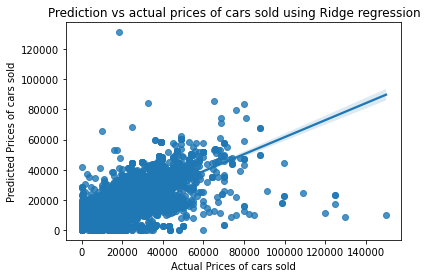

In [51]:
# Creating a plot of the predicted price and the actual price to see the correlation. Given the correlation is fairly linear we can 
#safely assume that the model is a good fit
sns.regplot(x= np.exp(y_test),y= np.exp(ridge_test_preds_opt), marker='o')
plt.xlabel("Actual Prices of cars sold")
plt.ylabel("Predicted Prices of cars sold")
plt.title("Prediction vs actual prices of cars sold using Ridge regression" )
plt.show()

In [52]:
#Creating a dataframe of actual car prices from our existing data
Actual_prices_df= pd.DataFrame(np.exp(y_test))

#Creating a dataframe of the predicted prices from our ridge model and renaming the column to predicted car prices
Prediction_prices_df= pd.DataFrame(np.exp(ridge_test_preds_opt))
Prediction_prices_df.rename(columns = { 0:'Predicted_Price'}, inplace = True)

#Assigning our test dataframe value to a new dataframe
Prediction_df = X_test

#Attaching the prices of the existing data with the existing parameters

Prediction_df['price'] = Actual_prices_df['price']

#Reseting the index to ensure that the predicted prices can be attached a complete dataframe can be made to make inferences.
Prediction_df = Prediction_df.reset_index()
Prediction_df['Predicted_Price'] = Prediction_prices_df['Predicted_Price']
Prediction_df.drop(['index'], axis=1, inplace=True)
Prediction_df.head()

age  condition    cylinders    fuel  odometer title_status transmission  \
0  11.0       good  4 cylinders     gas  104214.0        clean    automatic   
1  11.0  excellent  6 cylinders     gas  111099.0        clean    automatic   
2  15.0       good  8 cylinders     gas  109237.0        clean    automatic   
3  10.0  excellent  8 cylinders     gas  115517.0        clean    automatic   
4   6.0  excellent  6 cylinders  diesel   66600.0        clean    automatic   

  drive       size    type paint_color    price  Predicted_Price  
0   rwd    compact  pickup       white  10500.0     11060.395326  
1   fwd   mid-size     SUV        grey  11000.0      9141.997267  
2   4wd  full-size  pickup       black   8995.0     15750.823501  
3   4wd   mid-size   truck         red  14450.0     17990.155816  
4   4wd  full-size   truck       black  30813.0     42836.433033

In [53]:
# In order to improve readability of the plot dropping the mex value of the predicted price in the dataframe. 
#This results in better interpretation of values. This has been done only for graphing purposes.
max_predicted = Prediction_df['Predicted_Price'].max()
Prediction_df_box = Prediction_df
Prediction_df_box = Prediction_df_box[Prediction_df_box.Predicted_Price != max_predicted ]

In [54]:
# Creating a box plot using plotly to determine the predicted price based on the transmission type
px.box(Prediction_df_box, x='transmission', y='Predicted_Price',title ='Box plot of predicted prices based on transmission type')

In [55]:
# Creating a box plot using plotly to determine the predicted price based on the transmission type and vehicle size
px.box(Prediction_df_box, x='transmission', y='Predicted_Price',color = 'size', title ='Box plot of predicted prices based on transmission type for different vehicle sizes')

In [56]:
# Creating a box plot using plotly to determine the predicted price based on the vehicle cylinders
px.box(Prediction_df_box, x='cylinders', y='Predicted_Price', title ='Box plot of predicted prices based on cylinders')

In [57]:
# Creating a box plot using plotly to determine the predicted price based on the vehicle cylinders
px.box(Prediction_df_box, x='cylinders', y='Predicted_Price', color= 'transmission', title ='Box plot of predicted prices based on cylinders for various transmission types')

In [58]:
# Creating a box plot using plotly to determine the predicted price based on the vehicle cylinders
px.box(Prediction_df_box, x='cylinders', y='Predicted_Price', color = 'fuel', title ='Box plot of predicted prices based on cylinders for different fuel types')

In [59]:
# Creating a box plot of size of vehicle and predicted price
fig = px.box(Prediction_df_box, x="size", y="Predicted_Price",title = 'Box plot of predicted prices based on size of various vehicles')
fig.show()

In [60]:
# Creating a box plot of condition and predicted price
fig = px.box(Prediction_df_box, x="condition", y="Predicted_Price", color='transmission',
            title = 'Box plot of predicted prices based on condition for different transmission types')
fig.show()